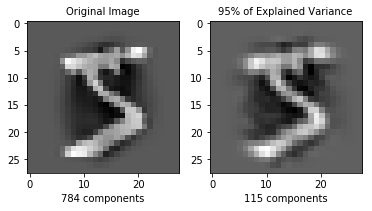

In [68]:
# References:
# 1. Image deskew: https://fsix.github.io/mnist/Deskewing.html

import timeit
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.ndimage import interpolation
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Functions to deskew the images
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix


def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

# Start the time to capture ru time
start = timeit.default_timer()

# Read the training data
data = np.genfromtxt("mnist_train.txt", delimiter=',')
label = data[:,0]
pixel = data[:,1:]

# Deskew the  training data data 
Deskewed_training_data =  deskewAll(pixel)

# Center the training data
center = preprocessing.StandardScaler(with_std=False).fit(Deskewed_training_data)
train_X = center.transform(Deskewed_training_data)

# Applying PCA to train data
pca = PCA(0.95)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) # This has reduced the data without loosing 95 % variance of the data.

approximation = pca.inverse_transform(reduced_data)

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[0].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[0].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('95% of Explained Variance', fontsize = 10);


# Read the test data
data_2 = np.genfromtxt("mnist_test.txt", delimiter=',')

# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)  

Validation Errors:
[0.01711680832121021, 0.01880017680104329, 0.015650021509870826, 0.016666743254370897, 0.016400076570036615, 0.016783354950854368, 0.0171667283225182, 0.017299830007649786, 0.01774982505181455, 0.01803318505282292]
                
Test Errors:
[0.027383594683246137, 0.031780929818099435, 0.026878598571956847, 0.029977989275966732, 0.02837907857371602, 0.028378241427813422, 0.030079347614334062, 0.029678824892449107, 0.031279589272585895, 0.031079751023337487]


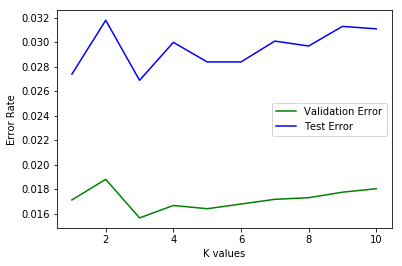

Wall time: 59min 55s


In [2]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
  
import matplotlib.pyplot as plt

data123 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label = data123[:,0]

x=[]
y=[]
z=[]
for i in range(10):
    k=i+1
    x.append(k)
    knn=KNeighborsClassifier(n_neighbors=k).fit(reduced_data,label)
    accuracies=cross_val_score(estimator=knn,X=reduced_data,y=label,cv=6)
    
    y.append(1-accuracies.mean())
    
for j in range(10):
    k=j+1
    knn=KNeighborsClassifier(n_neighbors=k).fit(reduced_data,label)
    accuracies=cross_val_score(estimator=knn,X=reduced_test_data,y=test_label,cv=6)
    z.append(1-accuracies.mean())
print("Validation Errors:")
print(y)
print('                ')
print("Test Errors:")
print(z)
plt.plot(x,y,'-g',label='Validation Error')
plt.plot(x,z,'-b',label='Test Error')
plt.xlabel( "K values")
plt.ylabel("Error Rate")
plt.legend()
plt.show()


In [69]:
%%time 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np


data1 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label = data1[:,0]

knn=KNeighborsClassifier(n_neighbors=3).fit(reduced_data,label)

y_pred=knn.predict(reduced_test_data)

accuracy=accuracy_score(test_label,y_pred)
error_rate1=1-accuracy

print("accuracy:",accuracy  )
print(error_rate)


accuracy: 0.9854
0.014599999999999946
Wall time: 2min 10s


In [70]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_label,y_pred)

array([[ 975,    1,    0,    0,    0,    0,    3,    1,    0,    0],
       [   0, 1131,    1,    1,    0,    1,    1,    0,    0,    0],
       [   4,    0, 1017,    1,    1,    0,    0,    5,    4,    0],
       [   1,    0,    3,  997,    0,    1,    0,    4,    3,    1],
       [   0,    0,    1,    0,  964,    0,    2,    0,    0,   15],
       [   3,    0,    0,    6,    2,  877,    3,    0,    0,    1],
       [   4,    3,    0,    0,    2,    1,  948,    0,    0,    0],
       [   1,    3,    5,    1,    2,    0,    0, 1013,    0,    3],
       [   7,    0,    1,    1,    2,    3,    1,    3,  954,    2],
       [   1,    2,    1,    4,    9,    5,    1,    7,    1,  978]],
      dtype=int64)

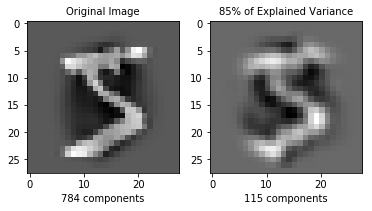

In [71]:
# References:
# 1. Image deskew: https://fsix.github.io/mnist/Deskewing.html

import timeit
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.ndimage import interpolation
from mpl_toolkits.axes_grid1 import AxesGrid 
from scipy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Functions to deskew the images
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix


def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

# Start the time to capture ru time
start = timeit.default_timer()

# Read the training data
data = np.genfromtxt("mnist_train.txt", delimiter=',')
label = data[:,0]
pixel = data[:,1:]

# Deskew the  training data data 
Deskewed_training_data =  deskewAll(pixel)

# Center the training data
center = preprocessing.StandardScaler(with_std=False).fit(Deskewed_training_data)
train_X = center.transform(Deskewed_training_data)

# Applying PCA to train data
pca = PCA(0.85)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) # This has reduced the data without loosing 95 % variance of the data.

approximation = pca.inverse_transform(reduced_data)

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[0].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[0].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('85% of Explained Variance', fontsize = 10);


# Read the test data
data_2 = np.genfromtxt("mnist_test.txt", delimiter=',')
 
# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)

Validation Errors:
[0.016733668253920086, 0.018250103367709936, 0.01550019980139894, 0.016216841523553183, 0.01600016983638841, 0.016350023226025523, 0.016683506597045983, 0.017116788260542748, 0.01708344159920705, 0.017616736677358635]
                
Test Errors:
[0.027184592496920512, 0.029982061488132428, 0.027080477242919954, 0.026382890789956037, 0.026580153038853638, 0.02788289241797448, 0.029280762231922774, 0.02928100401468725, 0.030280026481535383, 0.029880464169718457]


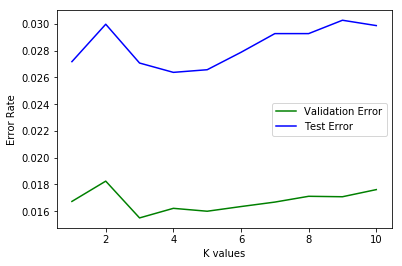

Wall time: 21min 48s


In [22]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
  
import matplotlib.pyplot as plt

data123 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label = data123[:,0]

x=[]
y=[]
z=[]
for i in range(10):
    k=i+1
    x.append(k)
    knn=KNeighborsClassifier(n_neighbors=k).fit(reduced_data,label)
    accuracies=cross_val_score(estimator=knn,X=reduced_data,y=label,cv=6)
    
    y.append(1-accuracies.mean())
    
for j in range(10):
    k=j+1
    knn=KNeighborsClassifier(n_neighbors=k).fit(reduced_data,label)
    accuracies=cross_val_score(estimator=knn,X=reduced_test_data,y=test_label,cv=6)
    z.append(1-accuracies.mean())
print("Validation Errors:")
print(y)
print('                ')
print("Test Errors:")
print(z)
plt.plot(x,y,'-g',label='Validation Error')
plt.plot(x,z,'-b',label='Test Error')
plt.xlabel( "K values")
plt.ylabel("Error Rate")
plt.legend()
plt.show()

In [72]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np


data1 = np.genfromtxt("mnist_test.txt", delimiter=',')
test_label = data1[:,0]

knn=KNeighborsClassifier(n_neighbors=3).fit(reduced_data,label)



y_pred=knn.predict(reduced_test_data) 
accuracy=accuracy_score(test_label,y_pred)
error_rate=1-accuracy

print("accuracy:",accuracy  )
print(error_rate)


accuracy: 0.9848
0.015199999999999991
Wall time: 48.6 s


In [73]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_label,y_pred)

array([[ 975,    0,    0,    0,    0,    0,    3,    1,    1,    0],
       [   0, 1131,    3,    0,    0,    0,    1,    0,    0,    0],
       [   3,    0, 1017,    2,    1,    0,    2,    3,    4,    0],
       [   1,    0,    4,  992,    0,    3,    0,    4,    6,    0],
       [   0,    1,    1,    0,  963,    0,    1,    1,    0,   15],
       [   4,    0,    0,    7,    2,  874,    2,    0,    1,    2],
       [   4,    3,    0,    0,    1,    0,  950,    0,    0,    0],
       [   1,    1,    5,    2,    1,    0,    0, 1011,    0,    7],
       [   3,    0,    2,    3,    2,    6,    1,    3,  952,    2],
       [   1,    0,    0,    5,   12,    3,    1,    3,    1,  983]],
      dtype=int64)

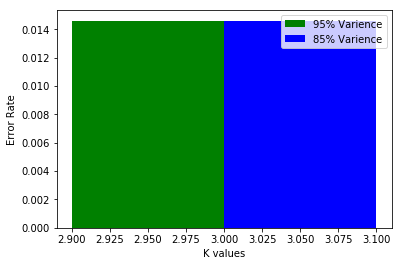

In [50]:
w=[2.95]
o=[3.05]

plt.bar(w,error_rate1,color='g',width=0.1,label='95% Varience')
plt.bar(o,error_rate,color='b',width=0.1,label='85% Varience')

plt.xlabel( "K values")
plt.ylabel("Error Rate")
plt.legend()
plt.show()